In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# For Hopkins Statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# For K Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For Hierarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [61]:
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [63]:
data[['exports','health','imports']] = data[['exports','health','imports']].apply(lambda x : x*data['gdpp']/100)

In [64]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [65]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


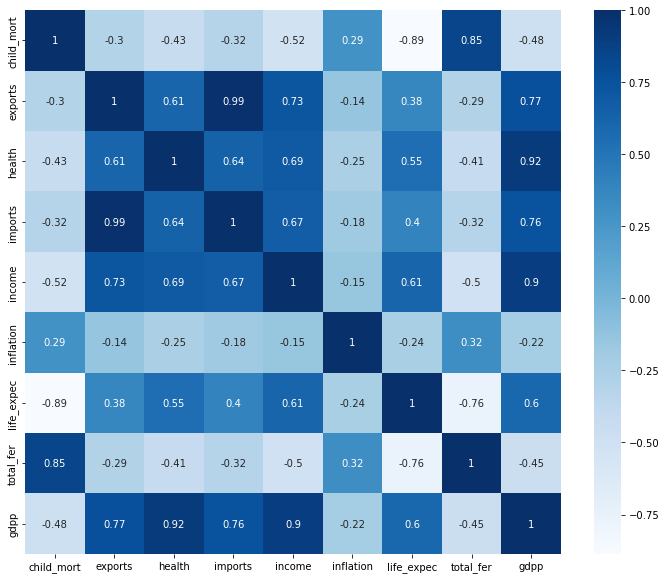

In [66]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(),annot=True, cmap='Blues')
plt.show()

In [67]:
# with the following function we can  select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(datasets,threshold):
    col_corr = set()   # set name of all the correlated columns
    corr_matrix = datasets.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) >= threshold: #  we are intrestedin absolute coeff value
                colname = corr_matrix.columns[i]   # getting name of column
                col_corr.add(colname)
    return col_corr
    

In [68]:
corr_feature = correlation(data,0.85)
len(set(corr_feature))

3

In [69]:
corr_feature

{'gdpp', 'imports', 'life_expec'}

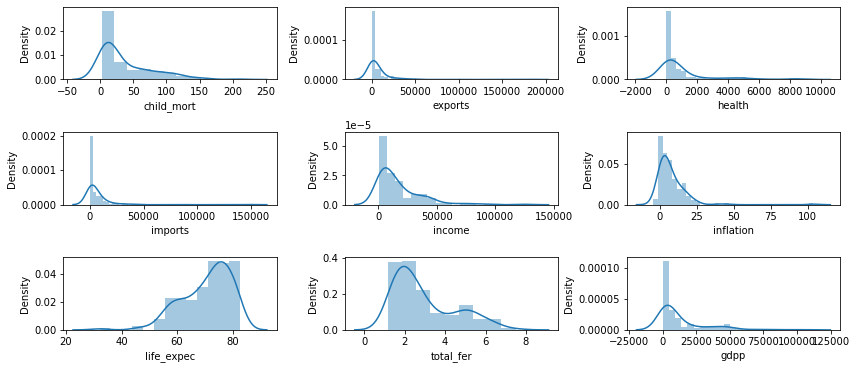

In [70]:
fig = plt.subplots(figsize=(12,10))
for i, feature in enumerate(data.drop('country', axis=1).columns):
    plt.subplot(6,3, i+1)
    plt.subplots_adjust(hspace=2.0)
    sns.distplot(data[feature])
    plt.tight_layout()

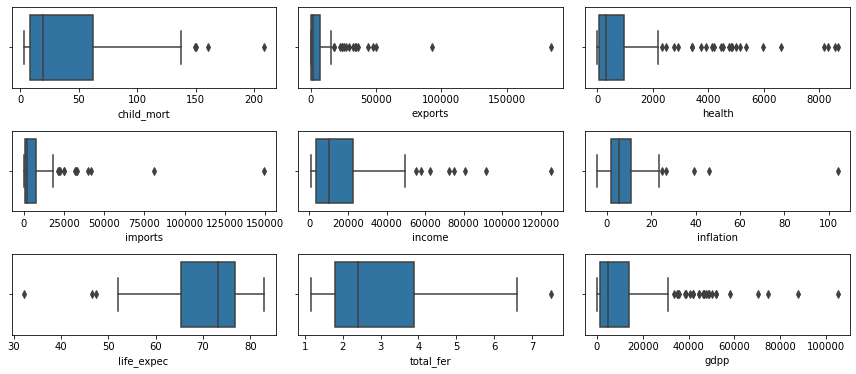

In [71]:
fig = plt.subplots(figsize=(12,10))
for i, feature in enumerate(data.drop('country', axis=1).columns):
    plt.subplot(6,3, i+1)
    plt.subplots_adjust(hspace=2.0)
    sns.boxplot(data[feature])
    plt.tight_layout()

In [72]:
data_updated = data.iloc[:,:]

def outliers_for_features(data, col):
    Q1 = data.loc[:,col].quantile(0.25)
    Q3 = data.loc[:,col].quantile(0.75)
    
    upper_limit = Q3 + 1.5*(Q3 - Q1)
    lower_limit = Q1 - 1.5*(Q3 - Q1)
    
    return data_updated[col].apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)

for col in data.columns[2:]:
    data_updated[col] = outliers_for_features(data,col)

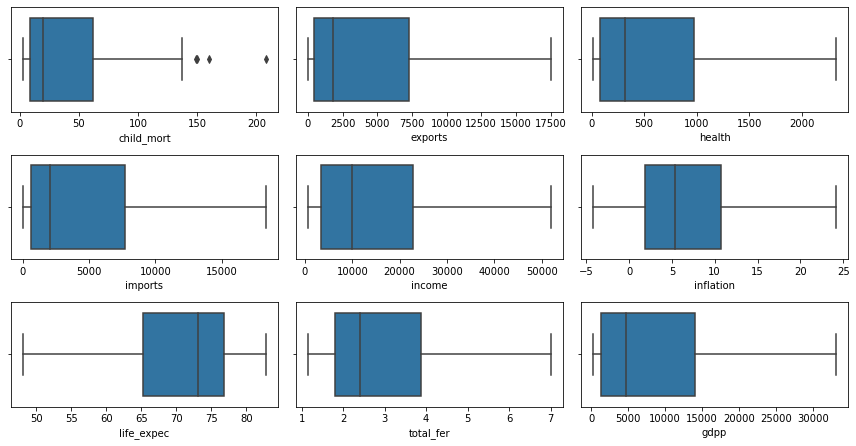

In [73]:
fig = plt.subplots(figsize=(12,12))
for i, feature in enumerate(data_updated.drop('country', axis=1).columns):
    plt.subplot(6,3, i+1)
    plt.subplots_adjust(hspace=2.0)
    sns.boxplot(data_updated[feature])
    plt.tight_layout()

In [74]:
data_updated

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950.0,2.62,63.0,3.50,2970.0
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500.0,24.16,75.4,2.47,13500.0
164,Vietnam,23.3,943.20,89.6040,1050.620,4490.0,12.10,73.1,1.95,1310.0
165,Yemen,56.3,393.00,67.8580,450.640,4480.0,23.60,67.5,4.67,1310.0


In [79]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [80]:
hopkins(data.drop('country', axis = 1))

0.8883307727662471

In [81]:
hopkins(data_updated.drop('country', axis = 1))

0.8810479269163165

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
scalar = StandardScaler()
scalar.fit(data_updated.iloc[:,1:])

StandardScaler()

In [86]:
scalar_data = scalar.transform(data_updated.iloc[:,1:])

In [87]:
df = pd.DataFrame(scalar_data,columns=data_updated.columns[1:])
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.800564,-0.795563,-0.794660,-0.943936,0.355270,-1.702225,1.915276,-0.846341
1,-0.538949,-0.613150,-0.513920,-0.488076,-0.395181,-0.385208,0.663321,-0.862779,-0.540827
2,-0.272833,-0.515576,-0.616010,-0.591590,-0.199291,1.351551,0.686859,-0.036691,-0.508868
3,2.007808,-0.431911,-0.722418,-0.571509,-0.660984,2.293979,-1.243238,2.141784,-0.589198
4,-0.695634,0.144450,0.069070,0.428104,0.209637,-0.841463,0.722166,-0.543003,0.159686


# Clustering
# K means

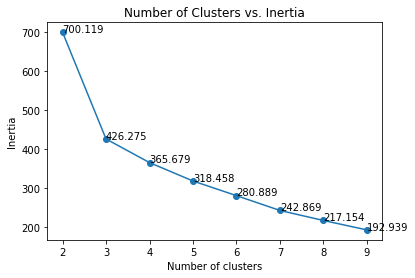

In [88]:
#Choosing k-value for K means algorithm
ssd = []
num_of_clusters = list(range(2,10))

for n in num_of_clusters:
    km = KMeans(n_clusters = n, max_iter = 50, random_state=101).fit(df)
    ssd.append(km.inertia_)
    
plt.plot(num_of_clusters, ssd, marker='o')

for xy in zip(num_of_clusters, ssd):    
    plt.annotate(s = round(xy[1],3), xy = xy,  textcoords='data')

plt.xlabel("Number of clusters")
plt.ylabel("Inertia") # Inertia is within cluster sum of squares
plt.title("Number of Clusters vs. Inertia")
plt.show()


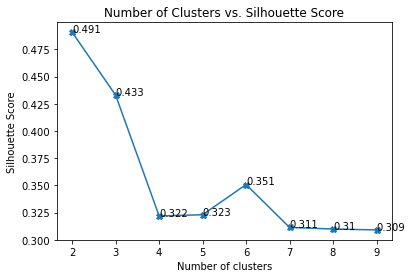

In [90]:
silhouette_value = []
for n in range(2,10):
    km = KMeans(n_clusters = n, random_state=101).fit(df)
    silhouette_value.append(silhouette_score(df, km.labels_))
    
plt.plot(num_of_clusters, silhouette_value, marker='X', label=silhouette_value)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Number of Clusters vs. Silhouette Score")

for xy in zip(num_of_clusters, silhouette_value):    
    plt.annotate(s = round(xy[1],3), xy = xy,  textcoords='data')
    
plt.show()

Comment: K=2 has highest Silhouette score but it will make more sense to take more than 2 clusters for under-developed, developing and developed countries.

Hence k=3 is closen.


In [91]:
# Building K Means model with 3 clusters
km = KMeans(n_clusters=3, max_iter=100 , random_state = 101)
km.fit(df)

KMeans(max_iter=100, n_clusters=3, random_state=101)

In [92]:
print(km.labels_)
print(km.labels_.shape)

[2 1 1 2 1 1 1 0 0 1 0 0 1 1 1 0 1 2 1 1 1 1 1 0 1 2 2 1 2 0 1 2 2 1 1 1 2
 2 2 1 2 1 0 0 0 1 1 1 1 2 2 0 1 0 0 2 2 1 0 2 0 1 1 2 2 1 2 0 0 1 1 1 2 0
 0 0 1 0 1 1 2 2 0 1 2 1 1 2 2 1 1 0 1 2 2 1 1 2 0 2 1 1 1 1 1 1 2 1 2 1 0
 0 2 2 0 0 2 1 1 1 1 1 0 0 1 1 2 1 0 2 1 1 2 0 0 0 2 1 0 0 1 1 2 1 0 0 1 2
 1 2 2 1 1 1 1 2 1 0 0 0 1 1 1 1 1 2 2]
(167,)


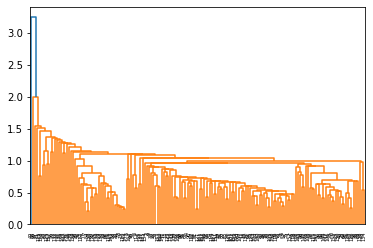

In [93]:
### Hierarchical Clustering
mergings_single = linkage(df, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()



Comment:

    With single linkage clusters are not interpretable.
    Using complete linkage.



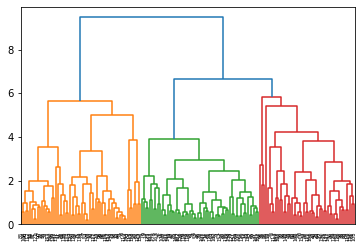

In [94]:
mergings_complete = linkage(df, method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

In [97]:
# Taking 3 clusters for hierarchical clustering
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
print(cluster_labels)
print(cluster_labels.shape)

[0 1 1 0 2 1 1 2 2 1 2 2 1 2 1 2 1 0 1 1 1 0 2 2 1 0 0 1 0 2 1 0 0 2 1 1 0
 0 0 2 0 2 2 2 2 1 1 1 1 0 0 2 1 2 2 0 0 1 2 0 2 1 1 0 0 1 0 2 2 1 1 1 0 2
 2 2 1 2 1 1 0 0 2 1 0 2 2 0 0 2 2 2 1 0 0 2 2 0 2 0 1 1 1 1 2 1 0 1 0 1 2
 2 0 0 2 2 0 2 1 1 1 2 2 2 1 1 0 1 2 0 1 2 0 2 2 2 0 0 2 2 1 1 0 2 2 2 1 0
 1 0 0 1 1 2 1 0 1 2 2 2 2 1 1 1 1 0 0]
(167,)


In [98]:
country_df_clustered = data_updated.iloc[:,:]
country_df_clustered = pd.concat([country_df_clustered, pd.DataFrame(km.labels_, columns=['cluster_id_km'])], axis = 1)
country_df_clustered = pd.concat([country_df_clustered, pd.DataFrame(cluster_labels, columns=['cluster_id_hc'])], axis = 1)
country_df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1,2


In [99]:
print(country_df_clustered['cluster_id_km'].value_counts())
print(country_df_clustered['cluster_id_hc'].value_counts())

1    80
2    46
0    41
Name: cluster_id_km, dtype: int64
2    60
1    59
0    48
Name: cluster_id_hc, dtype: int64


In [100]:
print("Cluster 0 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 0].country.unique())

print("Cluster 1 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 1].country.unique())

print("Cluster 2 of Hierarchical Clustering model")
print(country_df_clustered[country_df_clustered['cluster_id_hc'] == 2].country.unique())

Cluster 0 of Hierarchical Clustering model
['Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tanzania' 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia']
Cluster 1 of Hierarchical Clustering model
['Albania' 'Algeria' 'Argentina' 'Armenia' 'Azerbaijan' 'Bangladesh'
 'Belarus' 'Belize' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Bulgaria'
 'Cambodia' 'Cape Verde' 'China' 'Colombia' 'Dominican Republic' 'Ecuador'
 'Egypt' 'El Salvador' 'Fiji' 'Georgia' 'Grenada' 'Guatemala' 'Guyana'
 'India' 'Indonesia' 'Iran' 'Jamaica' 'Jordan' 'Kazakhstan'
 'Kyrgyz Republic

In [101]:
print("Cluster 0 of KMeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 0].country.unique())

print("Cluster 1 of KMeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 1].country.unique())

print("Cluster 2 of KMeans model")
print(country_df_clustered[country_df_clustered['cluster_id_km'] == 2].country.unique())

Cluster 0 of KMeans model
['Australia' 'Austria' 'Bahamas' 'Bahrain' 'Belgium' 'Brunei' 'Canada'
 'Cyprus' 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kuwait' 'Luxembourg' 'Malta' 'Netherlands' 'New Zealand' 'Norway' 'Oman'
 'Portugal' 'Qatar' 'Saudi Arabia' 'Singapore' 'Slovak Republic'
 'Slovenia' 'South Korea' 'Spain' 'Sweden' 'Switzerland'
 'United Arab Emirates' 'United Kingdom' 'United States']
Cluster 1 of KMeans model
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Bulgaria'
 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Fiji' 'Georgia'
 'Grenada' 'Guatemala' 'Guyana' 'India' 'Indonesia' 'Iran' 'Jamaica'
 'Jordan' 'Kazakhstan' 'Kyrgyz Republic' 'Latvia' 'Lebanon' 'Libya'


# Cluster Profiling

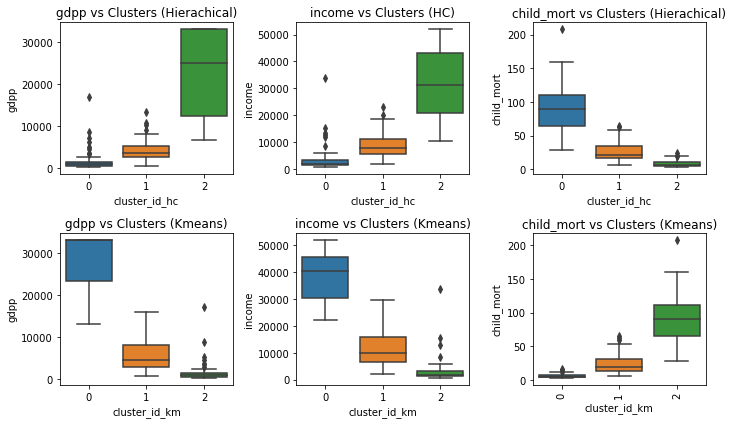

In [103]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 3, 1, title="gdpp vs Clusters (Hierachical)")
ax4 = fig.add_subplot(2, 3, 4, title="gdpp vs Clusters (Kmeans)")

ax2 = fig.add_subplot(2, 3, 2, title="income vs Clusters (HC)")
ax5 = fig.add_subplot(2, 3, 5, title="income vs Clusters (Kmeans)")

ax3 = fig.add_subplot(2, 3, 3, title="child_mort vs Clusters (Hierachical)")
ax6 = fig.add_subplot(2, 3, 6, title="child_mort vs Clusters (Kmeans)")

sns.boxplot(country_df_clustered['cluster_id_hc'],country_df_clustered['gdpp'],ax=ax1)
sns.boxplot(country_df_clustered['cluster_id_km'],country_df_clustered['gdpp'],ax=ax4)

sns.boxplot(country_df_clustered['cluster_id_hc'],country_df_clustered['income'],ax=ax2)
sns.boxplot(country_df_clustered['cluster_id_km'],country_df_clustered['income'],ax=ax5)

sns.boxplot(country_df_clustered['cluster_id_hc'],country_df_clustered['child_mort'],ax=ax3)
sns.boxplot(country_df_clustered['cluster_id_km'],country_df_clustered['child_mort'],ax=ax6)


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

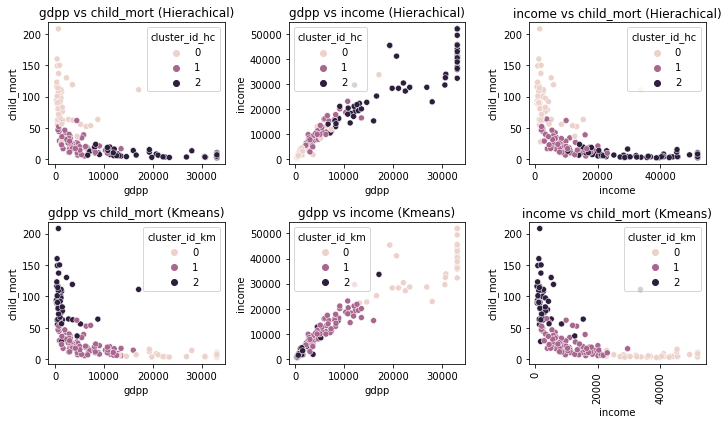

In [104]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 3, 1, title="gdpp vs child_mort (Hierachical)")
ax4 = fig.add_subplot(2, 3, 4, title="gdpp vs child_mort (Kmeans)")

ax2 = fig.add_subplot(2, 3, 2, title="gdpp vs income (Hierachical)")
ax5 = fig.add_subplot(2, 3, 5, title="gdpp vs income (Kmeans)")

ax3 = fig.add_subplot(2, 3, 3, title="income vs child_mort (Hierachical)")
ax6 = fig.add_subplot(2, 3, 6, title="income vs child_mort (Kmeans)")

sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['child_mort'],hue=country_df_clustered['cluster_id_hc'],ax=ax1)
sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['child_mort'],hue=country_df_clustered['cluster_id_km'],ax=ax4)

sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['income'],hue=country_df_clustered['cluster_id_hc'],ax=ax2)
sns.scatterplot(country_df_clustered['gdpp'],country_df_clustered['income'],hue=country_df_clustered['cluster_id_km'],ax=ax5)

sns.scatterplot(country_df_clustered['income'],country_df_clustered['child_mort'],hue=country_df_clustered['cluster_id_hc'],ax=ax3)
sns.scatterplot(country_df_clustered['income'],country_df_clustered['child_mort'],hue=country_df_clustered['cluster_id_km'],ax=ax6)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [105]:
country_df_clustered.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id_km,cluster_id_hc
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1,2


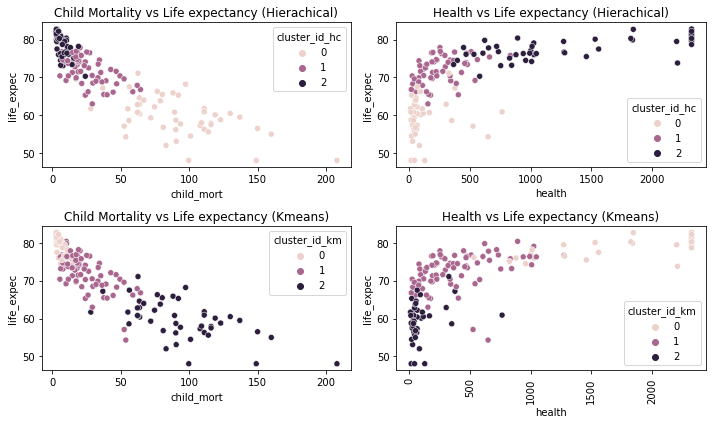

In [106]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 2, 1, title="Child Mortality vs Life expectancy (Hierachical)")
ax3 = fig.add_subplot(2, 2, 3, title="Child Mortality vs Life expectancy (Kmeans)")
ax2 = fig.add_subplot(2, 2, 2, title="Health vs Life expectancy (Hierachical)")
ax4 = fig.add_subplot(2, 2, 4, title="Health vs Life expectancy (Kmeans)")

sns.scatterplot(country_df_clustered['child_mort'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_hc'],ax=ax1)
sns.scatterplot(country_df_clustered['child_mort'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_km'],ax=ax3)
sns.scatterplot(country_df_clustered['health'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_hc'],ax=ax2)
sns.scatterplot(country_df_clustered['health'],country_df_clustered['life_expec'],hue=country_df_clustered['cluster_id_km'],ax=ax4)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [111]:
# Under-developed countries obtained from both the model

country_df_clustered[(country_df_clustered['cluster_id_hc']==0) | (country_df_clustered['cluster_id_km']==1)].sort_values(by=['gdpp', 'income', 'child_mort'],ascending=['True', 'True', 'False'])[['country','cluster_id_hc','cluster_id_km']]

,country,cluster_id_hc,cluster_id_km
26,Burundi,0,2
88,Liberia,0,2
37,"Congo, Dem. Rep.",0,2
112,Niger,0,2
132,Sierra Leone,0,2
...,...,...,...
33,Chile,2,1
163,Venezuela,1,1
41,Croatia,2,1
13,Barbados,2,1


In [108]:
country_df_clustered[(country_df_clustered['cluster_id_hc']==0)].sort_values(by=['gdpp', 'income', 'child_mort'], ascending=['True', 'True', 'False'])[['country']]

,country
26,Burundi
88,Liberia
37,"Congo, Dem. Rep."
112,Niger
132,Sierra Leone
93,Madagascar
106,Mozambique
31,Central African Republic
94,Malawi
50,Eritrea
